<a href="https://colab.research.google.com/github/Klushnichenko/diplom/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C(%D0%B4%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC)_ipynb___ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#необходимые библиотеки
import pandas as pd
import numpy as np
import random
import pickle
import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#чтение набора и вывод кол-во записей и признаков
model = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', engine='python')
model.shape

(458968, 85)

In [ ]:
#предварительная обработка,исключение признака «Fwd Header Length.1
model.columns = model.columns.str.strip()
model = model.drop(columns=['Fwd Header Length.1'])
print(model.shape)
#model['Label'].value_counts() #чтобы посмотреть сколько всего записей на каждый вид атаки

(1048574, 84)


In [ ]:
#предварительная обработка
model = model.drop(model[pd.isnull(model['Flow ID'])].index)
model.replace('Infinity', -1, inplace=True)
model[["Flow Bytes/s", "Flow Packets/s"]] = model[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric)
model.replace([np.inf, -np.inf, np.nan], -1, inplace=True)
string_features = list(model.select_dtypes(include=['object']).columns)
string_features.remove('Label')
a = preprocessing.LabelEncoder()
model[string_features] = model[string_features].apply(lambda col: a.fit_transform(col))

In [ ]:
model.shape

(863069, 84)

In [ ]:
benign = len(model[model['Label'] == "BENIGN"])
print('кол-во записей с нормальным трафиком: ',benign) 
attack = len(model[model['Label'] != "BENIGN"])
print('кол-во записей атак: ',attack) 
model.to_csv("unbalanced.csv", index=False) #новый файл с несбалансированным набором
#model['Label'].value_counts()

кол-во записей с нормальным трафиком:  608217
кол-во записей атак:  254852


In [ ]:
model.shape

(863069, 84)

In [ ]:
#метод случайного сэмплирования, а именно субдискретизация 
enlargement = 1.1
benign_included_max = attack / 30 * 70
benign_inc_probability = (benign_included_max / benign) * enlargement
#print(benign_included_max, benign_inc_probability)

In [ ]:
#формирование данных для файла с сбалансированным набором
indexes = []
benign_included_count = 0
for index, row in model.iterrows():
    if (row['Label'] != "BENIGN"):
        indexes.append(index)
    else:
        if random.random() > benign_inc_probability: continue
        if benign_included_count > benign_included_max: continue
        benign_included_count += 1
        indexes.append(index)
model_balanced = model.loc[indexes]

In [ ]:
#print(model_balanced['Label'].value_counts())
model_balanced.to_csv("balanced.csv", index=False)

In [ ]:
#убираются те признаки, которые учитываться не будут
model = pd.read_csv('balanced.csv')
model['Label'] = model['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
del1 = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp']
model = model.drop(columns=del1, errors='ignore')
del2 = ['Init_Win_bytes_backward', 'Init_Win_bytes_forward']
model = model.drop(columns=del2, errors='ignore')

In [ ]:
y = model['Label'].values
X = model.drop(columns=['Label'])
print(X.shape, y.shape)

(849507, 74) (849507,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
#обучение модели со всеми признаками, чтобы выделить наиболее важные
tr = RandomForestClassifier(n_estimators=250, random_state=42, oob_score=True)
tr.fit(X_train, y_train)

RandomForestClassifier(n_estimators=250, oob_score=True, random_state=42)

In [ ]:
#формирование списка признаков
features = X.columns
importances = tr.feature_importances_
indices = np.argsort(importances)[::-1]
attack_features = []

for index, i in enumerate(indices[:20]):
    attack_features.append(features[i])

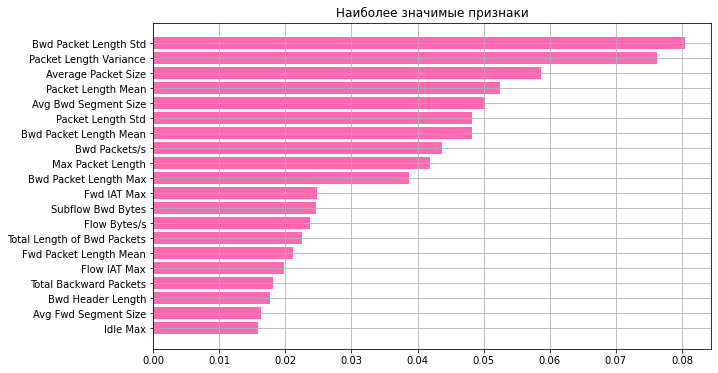

In [ ]:
#наглядный вывод наиболее значимых признаков
indices = np.argsort(importances)[-20:]
plt.rcParams['figure.figsize'] = (10, 6)
plt.title('Наиболее значимые признаки')
plt.barh(range(len(indices)), importances[indices], color='#ff69b4', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.grid()
plt.show()

In [ ]:
max_features = 20
attack_features = attack_features[:max_features]

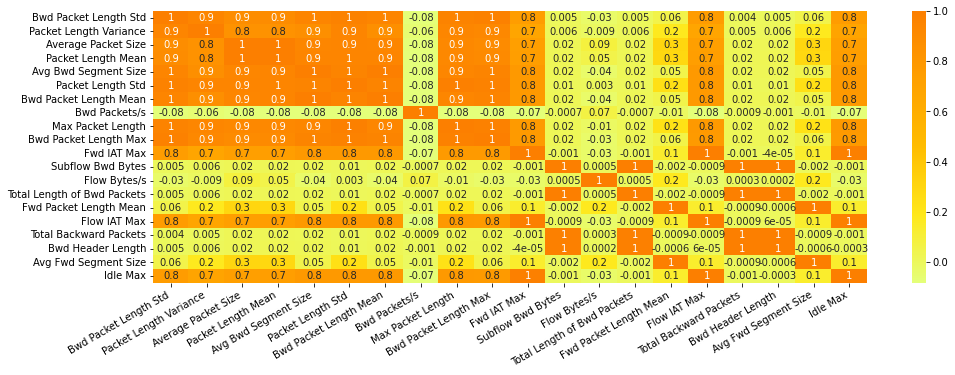

In [ ]:
#вариант сокращения признакового пространства с помощью коэффициентов корреляции Пирсона
corr_matrix = model[attack_features].corr()
plt.rcParams['figure.figsize'] = (16, 5)
g = sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Wistia')
g.set_xticklabels(g.get_xticklabels(), verticalalignment='top', horizontalalignment='right', rotation=30);

In [ ]:
to_be_removed = {'Packet Length Mean', 'Avg Fwd Segment Size', 'Subflow Fwd Bytes', 
                 'Fwd Packets/s', 'Fwd IAT Total', 'Fwd IAT Max'}
attack_features = [item for item in attack_features if item not in to_be_removed]
attack_features = attack_features[:10]

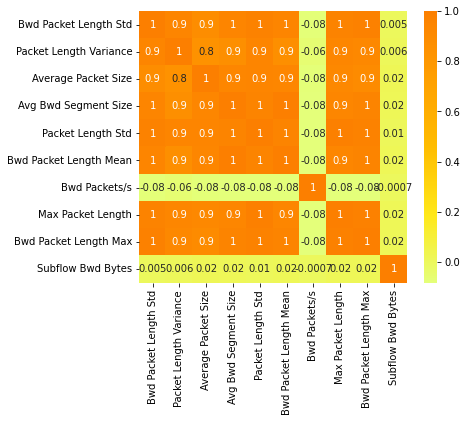

In [ ]:
corr_matrix = model[attack_features].corr()
plt.rcParams['figure.figsize'] = (6, 5)
sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Wistia');

In [ ]:
model = pd.read_csv('balanced.csv')
model['Label'] = model['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y = model['Label'].values
X = model[attack_features]
#print(X.shape, y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
#обучение модели с новыми признаками
tr = RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3, n_estimators=50, random_state=42, oob_score=True)
tr.fit(X_train, y_train)

RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3,
                       n_estimators=50, oob_score=True, random_state=42)

In [ ]:
#выделение уже наиболее значимых 10 признаков
features = X.columns
importances = tr.feature_importances_
indices = np.argsort(importances)[::-1]
    
for index, i in enumerate(indices[:10]):
    print('{}.\t#{}\t{:.3f}\t{}'.format(index + 1, i, importances[i], features[i]))

1.	#0	0.596	Bwd Packet Length Std
2.	#2	0.243	Average Packet Size
3.	#6	0.142	Bwd Packets/s
4.	#5	0.004	Bwd Packet Length Mean
5.	#3	0.004	Avg Bwd Segment Size
6.	#7	0.004	Max Packet Length
7.	#9	0.003	Subflow Bwd Bytes
8.	#1	0.002	Packet Length Variance
9.	#4	0.002	Packet Length Std
10.	#8	0.001	Bwd Packet Length Max


In [ ]:
y_pred = tr.predict(X_test)

In [ ]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy =', accuracy)

Accuracy = 0.9780893299274483


In [ ]:
#сохранение модели
with open('detection_model.pkl', 'wb') as f:
    pickle.dump(tr, f)

In [ ]:
with open('detection_model.pkl', 'rb') as f:
    tr = pickle.load(f)

In [ ]:
model = pd.read_csv('balanced.csv')
model['Label'] = model['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y_test = model['Label'].values
X_test = model[attack_features]

In [ ]:
#выполнение работы модели
y_pred = tr.predict(X_test)

print("Не обнаружено атак (0), Обнаружено атак (1):")
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

Не обнаружено атак (0), Обнаружено атак (1):


{0: 581047, 1: 268460}

In [ ]:
#мой набор данных
model = pd.read_csv('packets_train.csv')
y_test = model['Flow Key'].values
X_test = model[attack_features]


KeyError: ignored